In [1]:
import MySQLdb
import numpy as np   # numpy 패키지 불러오기 
import pandas as pd  # pandas 패키지 불러오기 
import matplotlib  # matplotlib 패키지 불러오기 
import matplotlib.pyplot as plt # 그래프 시각화를 위한 패키지 불러오기
import seaborn as sns  # seaborn 패키지 불러오기 
import warnings        # warings(경고 메시지 없애주는)패키지 불러오기 
warnings.filterwarnings('ignore')
from matplotlib import font_manager, rc  # matplotlib안 한글 깨짐 처리
import platform   # 현재 사용하고 있는 시스템 유형을 알려주는 패키지 
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell
from plotly.offline import iplot

# 한글 폰트 설정
import platform
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt

# 한글 사용시 마이너스 폰트가 깨지는 문제가 발생할 수 있으므로 설정 변경
plt.rcParams['axes.unicode_minus'] = False
if platform.system() == 'Windows':
    path = "c:/Windows/Fonts/NanumGothic.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
elif platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Linux':
    rc('font', family='NanumBarunGothic')
else:
    print('Unknown system... sorry~')

In [3]:
#1. 데이터 베이스 서버 접속 객체 만들기
connect_datas = {
    'host': '35.200.37.53',
    'user': 'root',
    'passwd': 'dss',
    'db': 'mydb',
    'charset': 'utf8'
}
connect_datas

{'host': '35.200.37.53',
 'user': 'root',
 'passwd': 'dss',
 'db': 'mydb',
 'charset': 'utf8'}

In [4]:
client = MySQLdb.connect(**connect_datas)
client

<_mysql.connection open to '35.200.37.53' at 0000025947C4ECF8>

In [5]:
# SQL 접속해서 read_sql -> csv 저장
# TV_daily_0 = pd.read_sql("SELECT  Year, Month, Day, Date, Advertiser, Target_Audience, Adience, GRP FROM mydb.TV_daily", client)
# TV_daily_0.to_csv("../datas/TV_daily_0.csv", encoding='utf-8', header=True)

In [5]:
 def tv_daily_df():
    TV_daily_0 = pd.read_csv("../datas/TV_daily_0.csv", encoding='utf-8')
    TV_daily_0['Date'] = [d[:11] for d in TV_daily_0['Date']]
    TV_daily_0['YM'] = [d[:7] for d in TV_daily_0['Date']]
    TV_daily_0['Date'] = pd.to_datetime(TV_daily_0['Date'])
    TV_daily_0['Week'] = TV_daily_0['Date'].dt.dayofweek #월0 ~일6 #day_name()
    TV_daily_0['Month'] = [int(m[:-1]) for m in TV_daily_0['Month']]
    TV_daily_0['Sex'] = [s[0] if s != '개인' else '개인' for s in TV_daily_0['Target_Audience']]
    TV_daily_0['Age'] = [a[1:3] if a != '개인' else '개인' for a in TV_daily_0['Target_Audience']]
    return TV_daily_0

In [2]:
TV_daily_0 = tv_daily_df()
TV_daily_0['Advertiser'].unique()

array(['한국토요타자동차', '아우디폭스바겐코리아', '볼보자동차코리아', '포드세일즈서비스코리아', 'FMK',
       '혼다코리아', 'FCA코리아', '아우디코리아', '메르세데스벤츠코리아', '포르쉐코리아', 'BMW코리아',
       '재규어랜드로버코리아', '지엠아시아퍼시픽지역본부', '기흥인터내셔널', '에프씨에이코리아', '비워크', '한국닛산',
       '한불모터스', '캐딜락코리아', '지엠코리아', '더클래스효성', '도이치모터스'], dtype=object)

In [9]:
# defualt- 성별나이 무관: 전체 개인 고객

def making_ym_df(brand, sex='개인', age='개인'):
#     default - Target_Audience = '개인'
    TV_daily_0 = tv_daily_df()
    TV_daily_1 = TV_daily_0[TV_daily_0['Sex'] == sex][TV_daily_0['Age'] == age]
    df = TV_daily_1[TV_daily_1['Advertiser'] == brand]

    df_pv = pd.pivot_table(df, index=['Year','Month','Day','YM'],
                  aggfunc={'Adience':sum, 'GRP':sum, 'Week':'mean'}).reset_index()
    df_pv = pd.pivot_table(df_pv, index=['YM', 'Year','Month'],
                  aggfunc={'Day': 'count', 'Adience':sum, 'GRP':sum, 'Week':'mean'}).reset_index()
    df_pv_year = pd.pivot_table(df_pv, index=['Year'],
              aggfunc={'Day':sum, 'Adience':sum, 'GRP':sum, 'Week':'mean'})
    df_pv_year['Aud_avg'] = round(df_pv_year['Adience']/df_pv_year['Day'])
    df_pv_year['GRP_avg'] = df_pv_year['GRP']/df_pv_year['Day']
    return df_pv_year

In [33]:
def yearly_plot(brand):
    df_pv_year = making_ym_df(brand)
    fig, ax = plt.subplots(2, 2, figsize=(12, 8))
    x = df_pv_year.index.to_list()
    
    sns.barplot(data=df_pv_year, x=x, y='Adience', ax=ax[0,0], palette="Blues_d")
    sns.pointplot(data=df_pv_year, x=x, y='GRP', ax=ax[0,1], color='gray')
    sns.barplot(data=df_pv_year, x=x, y='Aud_avg', ax=ax[1,0], palette="Blues_d")
    sns.pointplot(data=df_pv_year, x=x, y='GRP_avg', ax=ax[1,1], color='gray')

    ax[0,0].set_title("Yearly Audience")
    ax[0,1].set_title("Yearly GRP")
    ax[1,0].set_title("Daily Avearge Audience")
    ax[1,1].set_title("Daily Avearge GRP")

    fig.tight_layout()
    plt.show()
#     iplot 그리기
#     df_pv_year.iplot(kind='bar', y='Aud_avg',title=f'{brand} 연도별 일평균 Audience')
#     df_pv_year.iplot(kind='line', y='GRP_avg',title=f'{brand} 연도별 일평균 GRP')

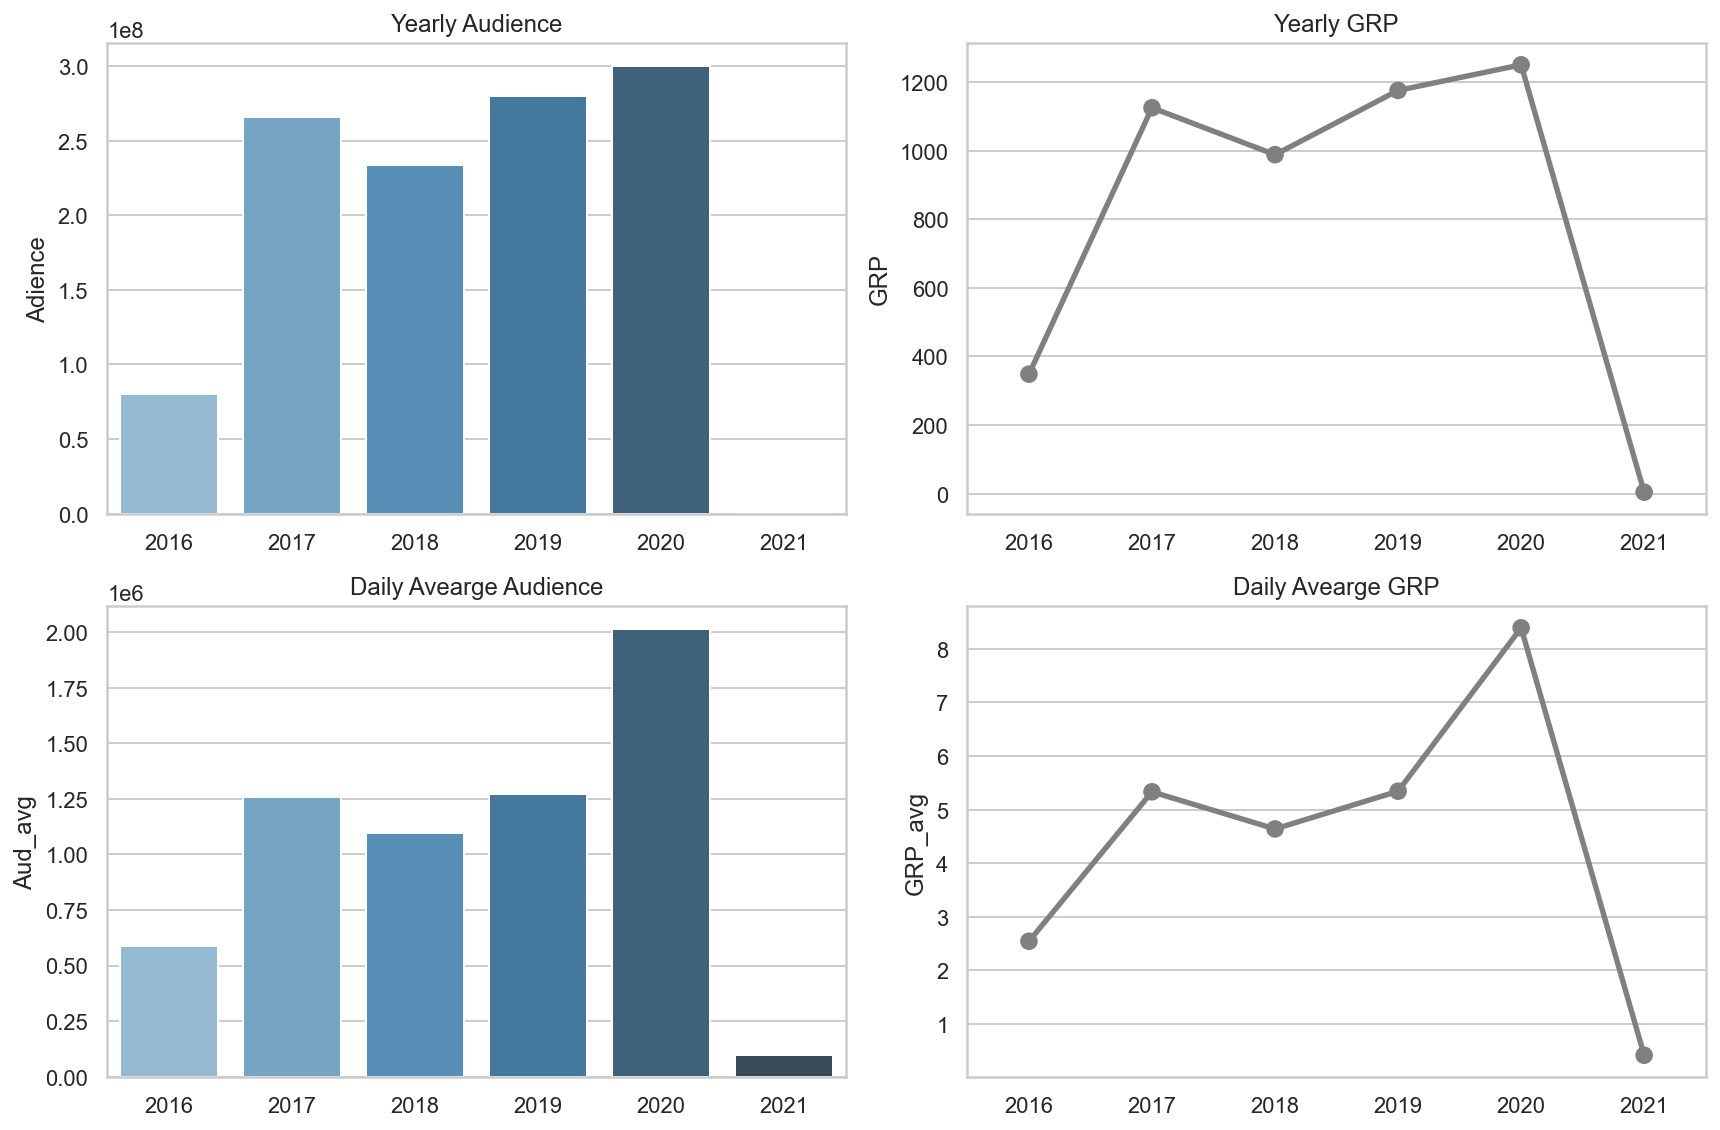

In [34]:
yearly_plot('메르세데스벤츠코리아')

In [217]:
ym_df = making_ym_df('메르세데스벤츠코리아')
start_y, start_d = 2021, 4
start_idx = ym_df[ym_df['Year']==start_y][ym_df['Month']==start_d].index[0]
ym_df = ym_df.iloc[start_idx-24:start_idx]

ym_df['GRP_cum'] = [sum(ym_df['GRP'].iloc[12:i+1]) for i in range(24)]
ym_df['GRP_ytd'] = [sum(ym_df['GRP'].iloc[i-11:i+1]) for i in range(24)]
ym_df['Aud_avg'] = round(ym_df['Adience']/ym_df['Day'])
ym_df['GRPavg'] = ym_df['GRP']/ym_df['Day']
ym_df['GRP_cumavg'] = [sum(ym_df['GRPavg'].iloc[12:i+1]) for i in range(24)]
ym_df['GRP_ytdavg'] = [sum(ym_df['GRPavg'].iloc[i-11:i+1]) for i in range(24)]
ym_df = ym_df.iloc[-12:]
ym_df

,YM,Year,Month,Adience,Day,GRP,Week,GRP_cum,GRP_ytd,Aud_avg,GRPavg,GRP_cumavg,GRP_ytdavg
29,2019-09,2019,9,738702,1,3.1,6.000000,3.1,1392.1,738702.0,3.100000,3.100000,60.479611
30,2019-11,2019,11,25325009,27,106.1,2.888889,109.2,1498.2,937963.0,3.929630,7.029630,64.409241
31,2019-12,2019,12,33741087,31,142.1,2.935484,251.3,1412.8,1088422.0,4.583871,11.613501,61.654402
32,2020-02,2020,2,12623450,4,52.8,4.500000,304.1,1296.0,3155862.0,13.200000,24.813501,69.201069
33,2020-03,2020,3,27884209,8,116.6,4.500000,420.7,1344.7,3485526.0,14.575000,39.388501,81.585746
34,2020-04,2020,4,21864437,4,91.5,4.500000,512.2,1237.8,5466109.0,22.875000,62.263501,86.424382
35,2020-05,2020,5,19470602,28,81.4,3.357143,593.6,1111.1,695379.0,2.907143,65.170643,81.899382
36,2020-09,2020,9,26317218,16,107.7,2.812500,701.3,1009.7,1644826.0,6.731250,71.901893,81.885471
37,2020-10,2020,10,58223770,31,240.3,3.096774,941.6,1250.0,1878186.0,7.751613,79.653506,89.637084
38,2020-11,2020,11,36697164,30,153.1,3.000000,1094.7,1402.5,1223239.0,5.103333,84.756840,94.685872


---

In [48]:
def making_aud_df(brand, year=2020):
    TV_daily_0 = tv_daily_df()
    TV_daily_0 = TV_daily_0[TV_daily_0['Advertiser'] == brand][TV_daily_0['Year'] == year]
    aud_df = TV_daily_0.drop(TV_daily_0[TV_daily_0['Target_Audience'] == '개인'].index ,axis=0)
    aud_df_pv = pd.pivot_table(aud_df, index=['Target_Audience', 'Sex','Age','Year','Month','Day','YM'],
                  aggfunc={'Adience':sum, 'GRP':sum, 'Week':'mean'}).reset_index()
    aud_df_pv = pd.pivot_table(aud_df, index=['Target_Audience','Sex','Age','YM', 'Year','Month'],
                  aggfunc={'Day': pd.Series.nunique, 'Adience':sum, 'GRP':sum, 'Week':'mean'}).reset_index()
    aud_df_pv = pd.pivot_table(aud_df, index=['Year','Target_Audience','Sex','Age'],
                aggfunc={'Day': sum, 'Adience':sum, 'GRP':sum}).reset_index()
    return aud_df_pv

In [49]:
making_aud_df('한국토요타자동차')

,Year,Target_Audience,Sex,Age,Adience,Day,GRP
0,2020,남20대,남,20,16652170,410793,962.5
1,2020,남30대,남,30,22718024,410793,1186.2
2,2020,남40대,남,40,54199827,410793,2585.7
3,2020,남50대,남,50,69782147,410793,3446.8
4,2020,남60대이상,남,60,72050537,410793,3311.6
5,2020,여20대,여,20,16499588,410793,989.3
6,2020,여30대,여,30,30653043,410793,1650.7
7,2020,여40대,여,40,57139744,410793,2740.4
8,2020,여50대,여,50,71756995,410793,3541.7
9,2020,여60대이상,여,60,64879839,410793,2491.6


In [119]:
def aud_ratio(brand, year=2020):
    aud_df_pv = making_aud_df(brand, year)
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    sns.despine(f)
    x_men = aud_df_pv[aud_df_pv['Sex']=='남']['Age'].to_list()
    y_men = aud_df_pv[aud_df_pv['Sex']=='남']['GRP'].to_list()
    x_women = aud_df_pv[aud_df_pv['Sex']=='여']['Age'].to_list()
    y_women = aud_df_pv[aud_df_pv['Sex']=='여']['GRP'].to_list()
    sns.barplot(x_men, y_men, label='Men', ax=ax, color="#ABC4EF")
    sns.barplot(x_women, y_women, label='Women', bottom=y_men, ax=ax, color="#F38394")
    
    ax.set_xlabel('Age')
    ax.set_ylabel('GRPs')
    ax.set_title('GRPs by age and gender')
    ax.legend()

    plt.show()

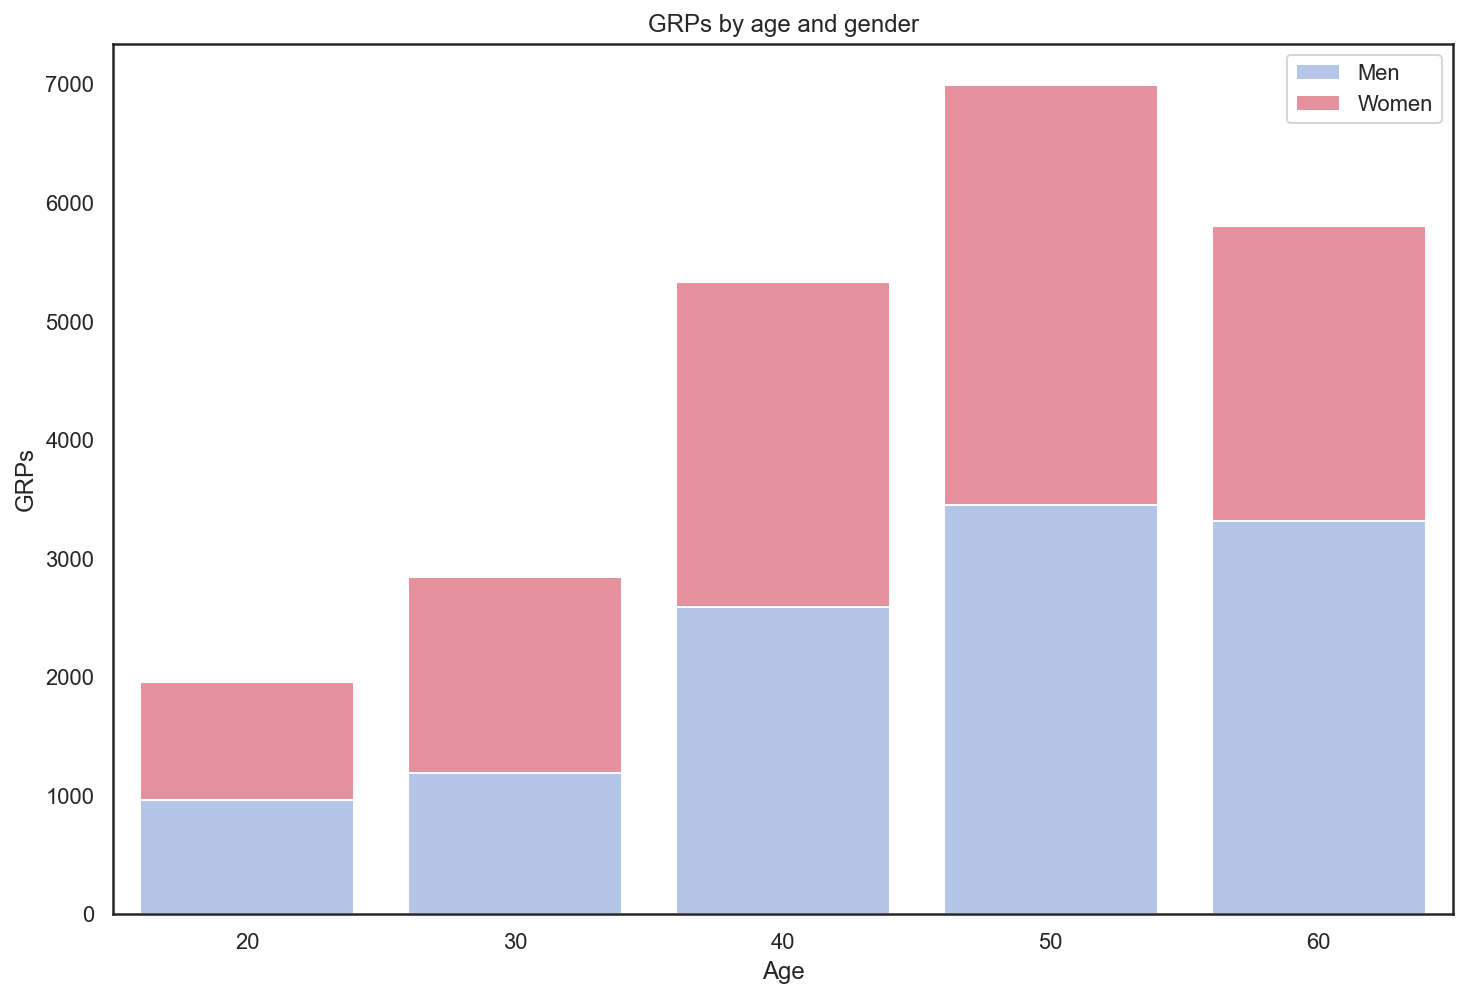

In [120]:
aud_ratio('한국토요타자동차')

In [108]:
def aud_ABC(brand, year=2020):
    aud_df_pv = making_aud_df(brand, year)
    aud_df_pv = aud_df_pv.sort_values(by='GRP', ascending=False)
    aud_df_pv['GRP_per'] = [g/sum(aud_df_pv['GRP'])*100 for g in aud_df_pv['GRP']]
    aud_df_pv['GRP_per_cum'] = [sum(aud_df_pv['GRP_per'].iloc[:i+1]) for i in range(len(aud_df_pv))]
    
    fig, ax1 = plt.subplots(figsize=(10,6))
    sns.set_style("white")
    ax1.set_title('ABC analysis of Audiences', fontsize=20)
    x = aud_df_pv['Target_Audience'].to_list()
    y = aud_df_pv['GRP_per'].to_list()
    y_cum = aud_df_pv['GRP_per_cum'].to_list()

    ax1.set_ylabel('Composition ratio %',fontsize=13)
    ax1 = sns.barplot(x, y, palette='summer')

    ax1.tick_params(axis='y')
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Cumulative composition ratio %',fontsize=13)
    sns.lineplot(x, y_cum, color='red')
    ax2.tick_params(axis='y')
    
    fig.show()

In [81]:
aud_df_pv = aud_df_pv.sort_values(by='GRP', ascending=False)
aud_df_pv['GRP_per'] = [g/sum(aud_df_pv['GRP'])*100 for g in aud_df_pv['GRP']]
aud_df_pv['GRP_per_cum'] = [sum(aud_df_pv['GRP_per'].iloc[:i+1]) for i in range(len(aud_df_pv))]
aud_df_pv

,Year,Target_Audience,Sex,Age,Adience,Day,GRP,cum_per,GRP_per,GRP_per_cum
8,2020,여50대,여,50,71756995,410793,3541.7,15.46,15.461550,15.461550
3,2020,남50대,남,50,69782147,410793,3446.8,15.05,15.047257,30.508808
4,2020,남60대이상,남,60,72050537,410793,3311.6,14.46,14.457032,44.965839
7,2020,여40대,여,40,57139744,410793,2740.4,11.96,11.963416,56.929256
2,2020,남40대,남,40,54199827,410793,2585.7,11.29,11.288062,68.217318
9,2020,여60대이상,여,60,64879839,410793,2491.6,10.88,10.877262,79.094580
6,2020,여30대,여,30,30653043,410793,1650.7,7.21,7.206252,86.300832
1,2020,남30대,남,30,22718024,410793,1186.2,5.18,5.178443,91.479274
5,2020,여20대,여,20,16499588,410793,989.3,4.32,4.318861,95.798136
0,2020,남20대,남,20,16652170,410793,962.5,4.20,4.201864,100.000000


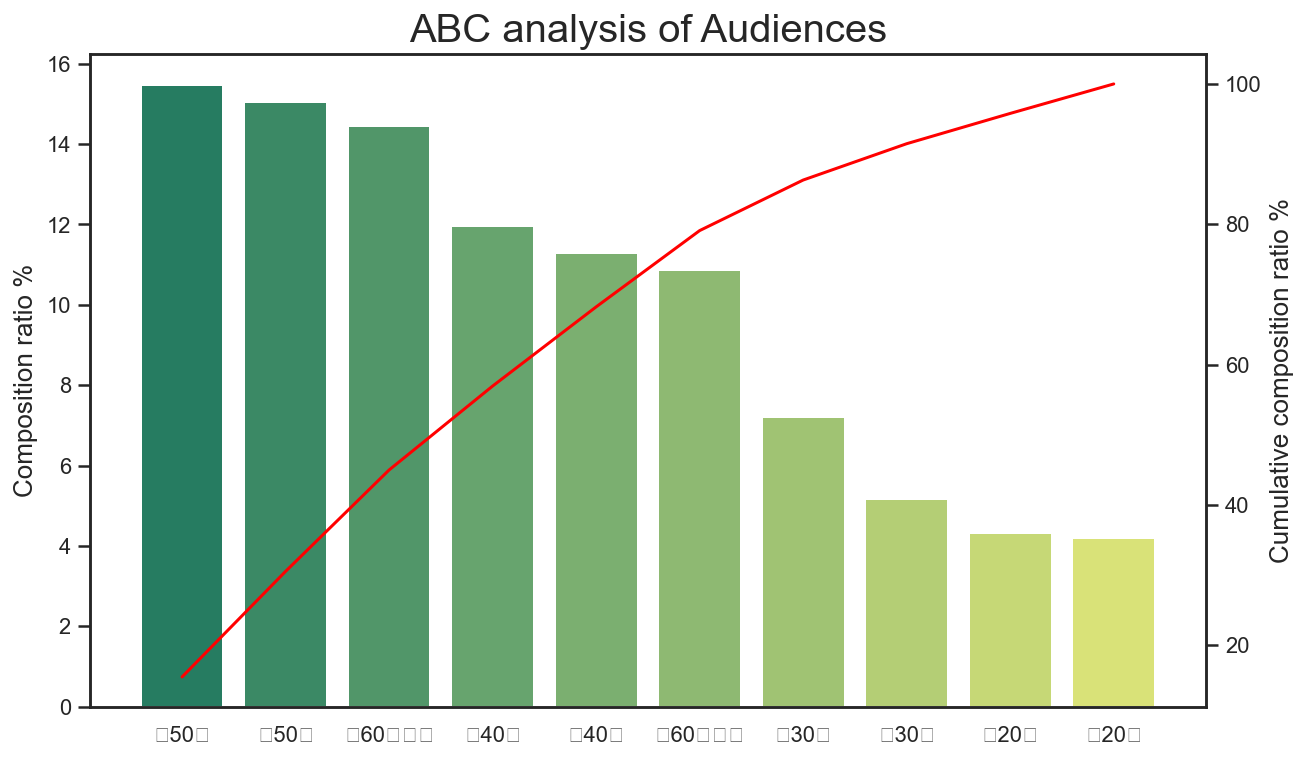

In [109]:
aud_ABC('한국토요타자동차')